In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame


In [2]:
client = CryptoHistoricalDataClient()

In [3]:
request_params = CryptoBarsRequest(
  symbol_or_symbols=["BTC/USD"],
  timeframe=TimeFrame.Day,
  start=datetime(2022, 9, 1),
  end=datetime(2026, 2, 22)
)

btc_bars = client.get_crypto_bars(request_params)
raw_df = btc_bars.df.reset_index()
raw_df = raw_df[raw_df["symbol"] == "BTC/USD"].copy()

raw_df.head()

,symbol,timestamp,open,high,low,close,volume,trade_count,vwap
0,BTC/USD,2022-09-01 00:00:00+00:00,20051.81,20205.83,19564.86,20132.97,7529.674053,114052.0,19934.701556
1,BTC/USD,2022-09-02 00:00:00+00:00,20132.50,20444.00,19757.72,19954.16,7392.679014,98745.0,20095.899441
2,BTC/USD,2022-09-03 00:00:00+00:00,19950.63,20054.69,19658.04,19832.06,3077.135497,52729.0,19839.406563
3,BTC/USD,2022-09-04 00:00:00+00:00,19834.87,20030.89,19587.86,20002.38,3712.178165,60722.0,19813.537532
4,BTC/USD,2022-09-05 00:00:00+00:00,19998.77,20058.00,19635.96,19795.12,4817.489036,66396.0,19801.578592


# Data preperation

In [4]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = raw_df.copy()

# Target: next day's closing price
df["target"] = df["close"].shift(-1)
df.dropna(inplace=True)

features = ["open","volume","high","low","trade_count",]

X = df[features]
y = df["target"]

print(f"Missing values:\n{X.isnull().sum()}")
print(f"\nDataset shape: {X.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale features (required for KNN and Lasso; harmless for tree models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Convert back to DataFrames for convenience
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test_scaled  = pd.DataFrame(X_test_scaled,  columns=features, index=X_test.index)

print(f"\nTrain size: {X_train_scaled.shape}, Test size: {X_test_scaled.shape}")
X_train_scaled.head()

Missing values:
open           0
volume         0
high           0
low            0
trade_count    0
dtype: int64

Dataset shape: (1270, 5)

Train size: (1016, 5), Test size: (254, 5)


,open,volume,high,low,trade_count
0,-1.115860,1.341052,-1.126089,-1.114011,1.088113
1,-1.112998,1.307642,-1.117797,-1.107049,0.875698
2,-1.119448,0.255174,-1.131352,-1.110647,0.237136
3,-1.123553,0.410048,-1.132180,-1.113181,0.348054
4,-1.117741,0.679609,-1.131237,-1.111444,0.426792


# Model train

MAE: $1,787.39
R²:  0.9740


c:\Users\david\anaconda3\envs\stock_predicter_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.213e+09, tolerance: 8.119e+07
  model = cd_fast.enet_coordinate_descent(


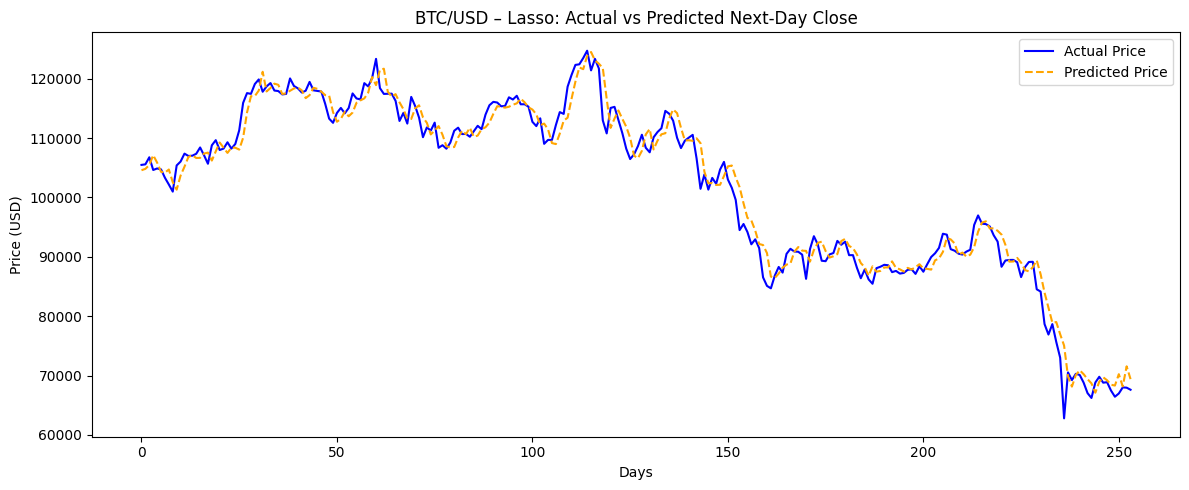

In [5]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, r2_score

lasso = Lasso(alpha=1)
lasso.fit(X_train_scaled, y_train)

# Use X_test_scaled — Lasso was trained on scaled features
predictions = lasso.predict(X_test_scaled)

# Evaluate
mae = mean_absolute_error(y_test, predictions)
r2  = r2_score(y_test, predictions)
print(f"MAE: ${mae:,.2f}")
print(f"R²:  {r2:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label="Actual Price", color="blue")
plt.plot(predictions, label="Predicted Price", color="orange", linestyle="--")
plt.title("BTC/USD – Lasso: Actual vs Predicted Next-Day Close")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
# Next-Day Prediction Bot

In [7]:
# Step 1: Retrain on ALL available data now that evaluation is done
# Using full data gives the model the most recent price patterns

scaler_full = StandardScaler()
X_full = df[features]
y_full = df["target"]

X_full_scaled = scaler_full.fit_transform(X_full)
X_full_scaled = pd.DataFrame(X_full_scaled, columns=features, index=X_full.index)

lasso_full = Lasso(alpha=1)
lasso_full.fit(X_full_scaled, y_full)
print("Model retrained on full dataset.")

Model retrained on full dataset.


c:\Users\david\anaconda3\envs\stock_predicter_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.911e+09, tolerance: 1.378e+08
  model = cd_fast.enet_coordinate_descent(


In [8]:
# Step 2: Predict tomorrow's BTC/USD closing price
# The last row of raw_df represents today's (most recent) candle

today = raw_df.iloc[-1]
today_date = pd.to_datetime(today["timestamp"]).date()

# Build the feature vector from today's OHLCV data
today_features = pd.DataFrame([{
    "open":        today["open"],
    "volume":      today["volume"],
    "high":        today["high"],
    "low":         today["low"],
    "trade_count": today["trade_count"],
}])

# Scale using the full-data scaler
today_scaled = scaler_full.transform(today_features)

# Predict
predicted_close = lasso_full.predict(today_scaled)[0]

print(f"Date used as input : {today_date}")
print(f"Today's close      : ${today['close']:,.2f}")
print(f"Predicted next-day close: ${predicted_close:,.2f}")
print(f"Expected move      : ${predicted_close - today['close']:+,.2f}  "
      f"({'▲' if predicted_close > today['close'] else '▼'})")

Date used as input : 2026-02-22
Today's close      : $67,605.82
Predicted next-day close: $67,599.53
Expected move      : $-6.29  (▼)


c:\Users\david\anaconda3\envs\stock_predicter_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
